## Analyzing outputs of 100 parameter sets ensemble simulaitons

Analyzing the first batch of ensemble simulations. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

### 1. Loading in parameter information

In [3]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671


### 2. Setting up xarray infrastructure to hold data

200423 - not sure if I'm actually going to store simulation output in xarray

In [4]:
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
df_siteinfo.head()

,site,city,state,lat,lon
0,03103,FLAGSTAFF,AZ,35.08,111.4
1,03812,ASHEVILLE,NC,35.26,82.32
2,03813,MACON,GA,32.42,83.39
3,03820,AUGUSTA,GA,33.22,81.58
4,03822,SAVANNAH,GA,32.08,81.12


In [5]:
sites = df_siteinfo.site
lat = df_siteinfo.lat
lon = df_siteinfo.lon
years = np.arange(1961,1991)
cultivars = np.arange(1,101)

In [6]:
ds = xr.Dataset()

### 3. Reading in simulation outputs

Thoughts: <br/>
Maybe I can create several pandas files that have sites as columns and time as rows. <br/>
I'll create 100 of these for all the cultivars. <br/>
I'll then use 'numpy.dstack' to stack all these 2d dataframes into a 3d matrix. <br/>
I'll then use this 3d matrix as the data input for xarray.

In [7]:
def get_filelist(path):
    '''
    For the given path, get the List of all files in the directory tree
    including those in subdirectories
    '''
    # create a list of file and sub directories names in the given directory 
    filelist = os.scandir(path)
    allfiles = list()
    # iterate over all the entries
    for entry in filelist:
        # create full path
        fullpath = os.path.join(path, entry)
        # if entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
    return allfiles

In [8]:
%%time
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')

CPU times: user 2.56 s, sys: 3.43 s, total: 6 s
Wall time: 2min 56s


In [64]:
# manual update of maizsim output column name
cols = ['jday', 'time', 'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 'RH', 
        'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

In [397]:
%%time

years = []
cvars = []
sites = []
biomass = []
ears = []
devstage = []

files = filelist[:]

for file in files:
    # extrating basic file info
    year = file.split('/')[-3]
    site = file.split('/')[-1].split('_')[1]
    var = file.split('/')[-1].split('_')[-1].split('.')[0]
    
    # reading in file and setting up structure
    try:
        with open(file, 'r') as f:
            f.seek(0, os.SEEK_END)
            f.seek(f.tell() - 3000, os.SEEK_SET) # reading in the last few lines
            for line in f:
                f_content = f.readlines()
                
        stage = f_content[-1].split(',')[-1].strip() # selecting last line - end point of simulation
        ear = float(f_content[-1].split(',')[-10]) # ear
        mass = float(f_content[-1].split(',')[-12]) # total biomass
    
        # compiling info
        years.append(year)
        cvars.append(var)
        sites.append(site)
        biomass.append(mass)
        ears.append(ear)
        devstage.append(stage)
        
    except:
        print(file)

/home/disk/eos8/ach315/upscale/sims/opt/1985/var_97/out1_24156_1985_var_97.txt
CPU times: user 36.5 s, sys: 20.5 s, total: 57 s
Wall time: 10min 57s


#### Storing final line of simulation as text file

In [401]:
sims_6190 = pd.DataFrame({'year': years,
                          'cultivar': cvars,
                          'site': sites,
                          'biomass': biomass,
                          'ear': ears,
                          'devstage': devstage})
sims_6190.to_csv('/home/disk/eos8/ach315/upscale/test/sims_6190.txt')

### 4. Reading in pre-stored final line of simulation and filtering out sites

In [4]:
# reading in raw simulation outputs
df_simulations = pd.read_csv('/home/disk/eos8/ach315/upscale/test/sims_6190.txt', index_col=0)
# reading in filtered sites
df_filtsites = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/sites_filtered.csv', index_col=0)
# merging two dataframes - filtering out unwanted sites - should only have 85 sites left
df_sims = pd.merge(df_simulations, df_filtsites, how='inner', on=['site', 'site'])
df_sims.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
0,1961,0,3820,47.734,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
1,1961,1,3820,109.384,29.88,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
2,1961,2,3820,148.455,9.52,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
3,1961,3,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
4,1961,4,3820,31.105,2.53,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


In [5]:
# Seperating out simulations that eneded in Maturation vs. those that didn't
df_matured = df_sims[df_sims.devstage == '"Matured"']
df_premature = df_sims[df_sims.devstage != '"Matured"']

In [6]:
df_sims.groupby('site').count()

,year,cultivar,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
site,,,,,,,,,,,,
3820,900,900,900,900,900,900,900,900,900,900,900,900
3856,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300
3927,600,600,600,600,600,600,600,600,600,600,600,600
3928,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100
3945,700,700,700,700,700,700,700,700,700,700,700,700
...,...,...,...,...,...,...,...,...,...,...,...,...
94830,1091,1091,1090,1091,1090,1091,1091,1091,1091,1091,1091,1091
94846,1590,1590,1589,1590,1589,1590,1590,1590,1590,1590,1590,1590
94847,1700,1700,1700,1700,1700,1700,1700,1700,1700,1700,1700,1700


In [8]:
df_sims.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
0,1961,0,3820,47.734,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
1,1961,1,3820,109.384,29.88,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
2,1961,2,3820,148.455,9.52,"""grainFill""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
3,1961,3,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
4,1961,4,3820,31.105,2.53,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


In [9]:
df_matured.head()

,year,cultivar,site,biomass,ear,devstage,years,city,state,lat,lon,area,perct_irri
0,1961,0,3820,47.734,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
3,1961,3,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
4,1961,4,3820,31.105,2.53,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
6,1961,6,3820,95.216,8.01,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754
7,1961,7,3820,0.352,0.00,"""Matured""",19,AUGUSTA,GA,33.22,81.58,53057.0,18.731754


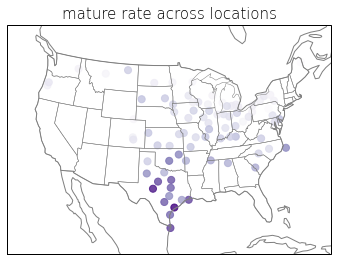

In [11]:
# maturate rate across sites
mature_rate = list((df_matured.groupby('site').count().year)/(df_sims.groupby('site').count().year))

# plotting map
from palettable.colorbrewer.sequential import Purples_9

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1, 
                     projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
ax.scatter(df_matured.groupby('site').mean().lon*-1, df_matured.groupby('site').mean().lat, 
           transform=ccrs.PlateCarree(), s=50, c=mature_rate, cmap=Purples_9.mpl_colormap, alpha=0.8)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('mature rate across locations', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/sites_weastation.png', format='png', dpi=800)


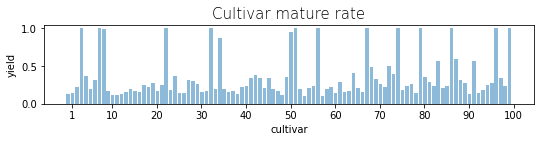

In [16]:
# mature rate across cultivars
mature_rate = list((df_matured.groupby('cultivar').count().year)/(df_sims.groupby('cultivar').count().year))

# plotting
x = np.arange(len(mature_rate))
width = 0.8
ticks = [0.5,9.5,19.5,29.5,39.5,49.5,59.5,69.5,79.5,89.5,99.5]
labels = [1,10,20,30,40,50,60,70,80,90,100]

fig, ax = plt.subplots(figsize=(8,2))
ax.bar(x-width/2, mature_rate, width, alpha=0.5)
ax.set_ylabel('yield')
ax.set_xlabel('cultivar')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title('Cultivar mature rate', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/var100_ear.png', format='png', dpi=800)

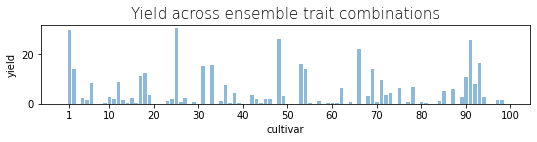

In [59]:
# yield across cultivars
means = test.groupby(['cultivar']).mean().ear
x = np.arange(len(means))
width = 0.8
ticks = [0.5,9.5,19.5,29.5,39.5,49.5,59.5,69.5,79.5,89.5,99.5]
labels = [1,10,20,30,40,50,60,70,80,90,100]

fig, ax = plt.subplots(figsize=(8,2))
ax.bar(x-width/2, means, width, alpha=0.5)
ax.set_ylabel('yield')
ax.set_xlabel('cultivar')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title('Yield across ensemble trait combinations', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/var100_ear.png', format='png', dpi=800)

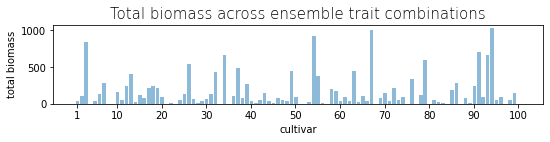

In [103]:
# total biomass across cultivars
means = df_matured.groupby(['cultivar']).mean().biomass
x = np.arange(len(means))
width = 0.8
ticks = [-0.5,8.5,18.5,28.5,38.5,48.5,58.5,68.5,78.5,88.5,98.5]
# not sure why ticks are slightly off 
# had to make this weird adjustment to make things match
labels = [1,10,20,30,40,50,60,70,80,90,100]


fig, ax = plt.subplots(figsize=(8,2))
ax.bar(x-width/2, means, width, alpha=0.5)
ax.set_ylabel('total biomass')
ax.set_xlabel('cultivar')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_title('Total biomass across ensemble trait combinations', fontweight='light', fontsize=15)
fig.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/var100_tbiomass.png', format='png', dpi=800)

### Looking into what site-year-cultivars failed to finish running

It could either be:
- issues with sites
- certain years
- certain cultivar combinations

In [17]:
test = pd.concat([df_params, pd.Series(df_matured.groupby('cultivar').mean().ear)], axis=1)
test.rename(columns={0:'ear'}, inplace=True)

In [19]:
test.columns

Index(['staygreen', 'rmax_lir', 'rmax_ltar', 'juv_leaves', 'leaf_wid',
       'WLRATIO', 'A_LW', 'LAF', 'f', 'scatt', 'vcm_25', 'vpm_25', 'g0', 'g1',
       't_opt', 'psi_threshold', 'ear'],
      dtype='object')

In [20]:
test.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold,ear
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627,0.015210
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151,29.743309
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541,14.029393
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738,0.000000
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671,2.430930


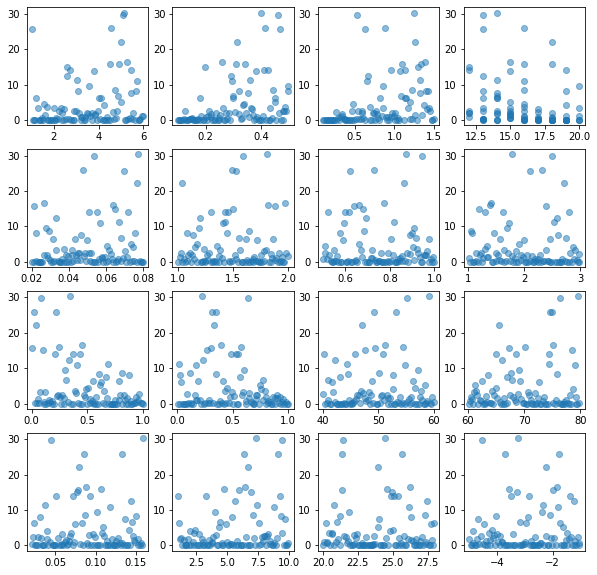

In [157]:
fig = plt.figure(figsize=(10,10))


for i in np.arange(1,17): 
    ax = fig.add_subplot(4,4,i)
    ax.scatter(test.iloc[:,i-1], test.iloc[:,-1], alpha=0.5)

In [31]:
test.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold,ear
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627,0.015210
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151,29.743309
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541,14.029393
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738,0.000000
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671,2.430930


In [29]:
from scipy import stats

In [33]:
stats.pearsonr(test.ear, test.juv_leaves)

(-0.24234404641571103, 0.015127925204801336)

In [36]:
stats.spearmanr(test.ear, test.juv_leaves)[0]

-0.3481379892121371

In [37]:
for i in np.arange(1,17): 
    spearmanr = stats.spearmanr(test.iloc[:,-1], test.iloc[:,i-1])[0]
    print(spearmanr)

0.2232431259896328
0.41302025526305086
0.5198609615841222
-0.3481379892121371
0.09549670887354558
-0.017256845373996323
0.03831910815077201
-0.08615175980849246
-0.23828415869871963
-0.08789791652812223
0.0018545388608481742
-0.06386116609790822
0.0043473281088713695
0.19436530658499696
-0.05189096072334274
0.039571524004851304


In [41]:
test.columns

Index(['staygreen', 'rmax_lir', 'rmax_ltar', 'juv_leaves', 'leaf_wid',
       'WLRATIO', 'A_LW', 'LAF', 'f', 'scatt', 'vcm_25', 'vpm_25', 'g0', 'g1',
       't_opt', 'psi_threshold', 'ear'],
      dtype='object')